# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [3]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [4]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,-116.125000,-163.350000,-9.125000,209.075000,-250.325000,-379.925000,-118.775000,-195.42500,82.850000,...,185.175000,641.250000,-14.800000,419.175000,-31.400000,818.875000,283.850000,11.425000,491.450000,-32.750000
std,0.49029,102.783364,95.437871,101.998539,111.000205,107.218776,123.026449,304.307494,100.91654,99.683743,...,87.141173,305.573085,92.745088,394.131039,54.429818,458.186178,197.123227,36.221461,653.148075,37.159221
min,0.00000,-476.000000,-531.000000,-168.000000,-24.000000,-496.000000,-696.000000,-1038.000000,-452.00000,-148.000000,...,42.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-100.000000,-33.000000,-108.000000
25%,0.00000,-140.750000,-208.500000,-81.250000,124.250000,-316.500000,-461.750000,-269.250000,-238.50000,-0.250000,...,133.750000,424.500000,-57.250000,241.750000,-57.250000,540.000000,189.000000,-8.250000,151.000000,-62.750000
50%,0.00000,-109.000000,-150.000000,-29.000000,228.000000,-225.000000,-384.500000,-77.000000,-172.00000,99.000000,...,179.500000,619.000000,10.500000,343.000000,-21.000000,747.000000,282.000000,10.000000,242.000000,-30.500000
75%,1.00000,-64.750000,-99.500000,47.000000,303.750000,-178.750000,-286.250000,20.500000,-125.75000,164.500000,...,227.000000,728.000000,52.250000,475.750000,11.250000,1042.500000,351.750000,28.250000,536.000000,-12.750000
max,1.00000,86.000000,-20.000000,262.000000,431.000000,-32.000000,-122.000000,367.000000,-11.00000,283.000000,...,413.000000,1655.000000,132.000000,2527.000000,50.000000,2313.000000,1108.000000,81.000000,3192.000000,78.000000


In [5]:
data_train.dtypes

Cancer_type         int64
AFFX-BioB-5_at      int64
AFFX-BioB-M_at      int64
AFFX-BioB-3_at      int64
AFFX-BioC-5_at      int64
AFFX-BioC-3_at      int64
AFFX-BioDn-5_at     int64
AFFX-BioDn-3_at     int64
AFFX-CreX-5_at      int64
AFFX-CreX-3_at      int64
AFFX-BioB-5_st      int64
AFFX-BioB-M_st      int64
AFFX-BioB-3_st      int64
AFFX-BioC-5_st      int64
AFFX-BioC-3_st      int64
AFFX-BioDn-5_st     int64
AFFX-BioDn-3_st     int64
AFFX-CreX-5_st      int64
AFFX-CreX-3_st      int64
hum_alu_at          int64
AFFX-DapX-5_at      int64
AFFX-DapX-M_at      int64
AFFX-DapX-3_at      int64
AFFX-LysX-5_at      int64
AFFX-LysX-M_at      int64
AFFX-LysX-3_at      int64
AFFX-PheX-5_at      int64
AFFX-PheX-M_at      int64
AFFX-PheX-3_at      int64
AFFX-ThrX-5_at      int64
                    ...  
X99479_f_at         int64
HG658-HT658_f_at    int64
M94880_f_at         int64
S80905_f_at         int64
X03068_f_at         int64
Z34822_f_at         int64
U87593_f_at         int64
U88902_cds1_

In [6]:
x_train = data_train.drop(['Cancer_type'], axis = 1)
x_test = data_test.drop(['Cancer_type'], axis = 1)
y_train = data_train['Cancer_type']
y_test = data_test['Cancer_type']

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

In [9]:
col_names = x_train.columns
x_train_norm = pd.DataFrame(x_train_norm, columns = col_names)
x_test_norm = pd.DataFrame(x_test_norm, columns = col_names)

In [10]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


Yes. Since there are more predictors than observations, any model will return a solution with a perfect fit to the training data. However, when performing predictions on a test set, the error will be quite large.

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

In [11]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

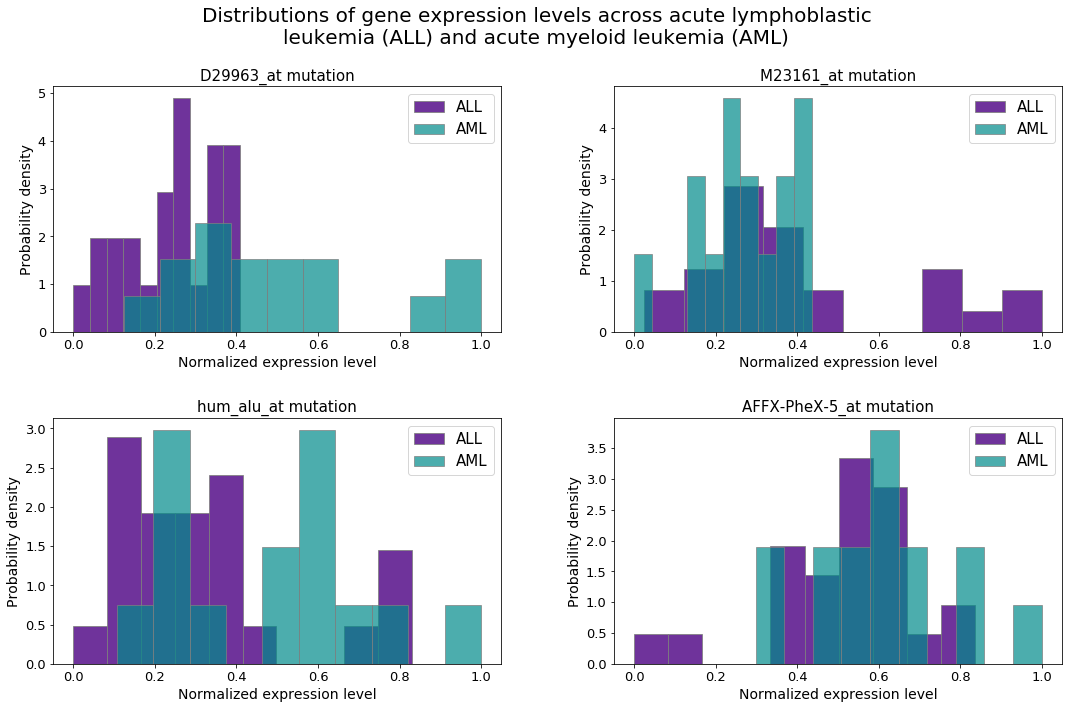

In [12]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize = (15, 10))
axs = axs.ravel()

colors = ['indigo','darkcyan']
gene_list = ['D29963_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at']
idx_ALL = np.where(y_train == 0)[0]
idx_AML = np.where(y_train == 1)[0]

for i, cur_gene in enumerate(gene_list):
    cur_df = x_train_norm[cur_gene]
    axs[i].hist(cur_df[idx_ALL], color = colors[0], label = 'ALL', alpha = 0.8, density = True, edgecolor = 'grey')
    axs[i].hist(cur_df[idx_AML], color = colors[1], label = 'AML', alpha = 0.7, density = True, edgecolor = 'grey')
    axs[i].set_title('{} mutation'.format(cur_gene), fontsize = 15)
    axs[i].legend(loc = 'best', fontsize = 15)
    axs[i].set_xlabel('Normalized expression level', fontsize = 14)
    axs[i].set_ylabel('Probability density', fontsize = 14)
    axs[i].tick_params(labelsize = 13)

fig.suptitle('Distributions of gene expression levels across acute lymphoblastic\nleukemia (ALL) \
and acute myeloid leukemia (AML)', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top = 0.87, hspace = .35, wspace = .25)

From these histograms, it appears that high expression levels of D29963_at (ie > 0.4 normalized expression level) are only found in AML, while lower expression levels are found in both cancer types; a mutation that causes over expression of D29963_at may be related to AML. High expression levels of M23161_at (ie > 0.6 normalized expression level) appear to only be found in ALL; a mutation that causes overexpression of M23161_at may be related to ALL. Low levels of the AFFX-PheX-5_at mutation (ie < 0.2) appear to only be present in ALL; a mutation that causes low expression of AFFX-PheX-5_at may be related to ALL. hum_alu_at doesn't appear to discriminate between the two cancers as much as the other three genes do.

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

In [13]:
pca_transformer = PCA(2).fit(x_train_norm)
x_train_2d = pca_transformer.transform(x_train_norm)
x_test_2d =  pca_transformer.transform(x_test_norm)

In [14]:
x_train_2d

array([[  5.45306938,   0.49770453],
       [ -2.67987934,   9.35271437],
       [ -8.93528413,  -3.59936564],
       [ 18.68968246,   8.07520703],
       [ -5.13355032,   0.31948604],
       [ 10.04931331,  21.54634308],
       [ -3.72274661,  -3.28414181],
       [  2.7876647 ,   6.06526714],
       [ -3.72948278,  -0.70848049],
       [ -3.1782392 ,   1.58288791],
       [  1.43017956,   3.48535137],
       [ -3.18285315,   0.44033841],
       [  0.97409371,   3.75065613],
       [  4.44492527,  -5.27019974],
       [  0.46446739,  -7.70285455],
       [  7.00065453,  -4.40307045],
       [  4.20591026,  -4.64334446],
       [  4.28192695,  -1.57818157],
       [ 14.83228638,  -8.17469706],
       [  0.05054541,  -3.80418522],
       [  1.01760361,  -5.71106715],
       [ -2.55108061,   1.70941966],
       [  3.42746757,  11.31130255],
       [ -7.44420683,   0.15654807],
       [-10.20691393,   1.4706251 ],
       [-10.38986959,   1.51658075],
       [ -1.13429464,   2.88433559],
 

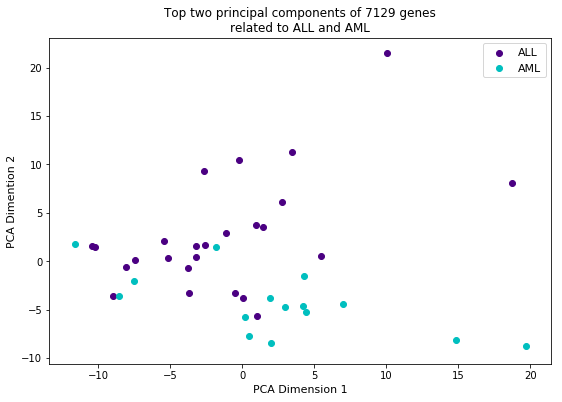

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

colors = ['indigo','c']
label_text = ['ALL', 'AML']

for cur_cancer in [0, 1]:
    cur_df = x_train_2d[np.where(y_train == cur_cancer)[0]]
    ax.scatter(cur_df[:,0], cur_df[:,1], color = colors[cur_cancer], label = label_text[cur_cancer])
    
ax.set_xlabel('PCA Dimension 1', fontsize = 11)
ax.set_ylabel('PCA Dimention 2', fontsize = 11)
ax.set_title('Top two principal components of 7129 genes\nrelated to ALL and AML', fontsize = 12)
ax.tick_params(labelsize = 10)
ax.legend(loc = 'best', fontsize = 11);

The top two principal components don't discriminate that well between ALL and AML. Only extreme cases of each principal component (ie both principal components > 10) discriminate between the two cancer types.

In [20]:
var_explained = pca_transformer.explained_variance_ratio_
print("Total Variance Explained:", np.sum(var_explained))

Total Variance Explained: 0.2731782945208866


Since the top two principal components don't account for even a third of the variance, it makes sense that the two don't discriminate well between ALL and AML.

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [21]:
from sklearn.linear_model import LinearRegression
gene_linreg = LinearRegression().fit(x_train_norm['D29963_at'].values.reshape(-1, 1), y_train)

Yes, there is a problem with this interpretation. We could get values of the predicted probability that are greater than 1 or less than 0, which is contrary to the measure of cancer type. 

**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [22]:
def cancer_class_acc(x_train, y_train, model) -> float:
    '''Takes feature dataset and response column and returns accuracy score for linear regression model
    Args:
        x_train: feature dataset
        y_train: response column
    Returns:
        accuracy of classification
    '''
    pred_prob = gene_linreg.predict(x_train.values.reshape(-1, 1))
    class_pred = np.zeros(len(x_train))
    for i, cur_pred in enumerate(pred_prob):
        if cur_pred > 0.5:
            class_pred[i] = 1
        else:
            class_pred[i] = 0
    class_pred = [int(line) for line in class_pred]
    result = accuracy_score(y_train, class_pred)
    return (result, pred_prob)

In [23]:
accuracy_train_lin, pred_quant_train = cancer_class_acc(x_train_norm['D29963_at'], y_train, gene_linreg)
accuracy_test_lin, pred_quant_test = cancer_class_acc(x_test_norm['D29963_at'], y_test, gene_linreg)

In [24]:
print('Training Classification Accuracy: {}'.format(accuracy_train_lin))
print('Test Classification Accuracy: {}'.format(accuracy_test_lin))

Training Classification Accuracy: 0.8
Test Classification Accuracy: 0.7575757575757576


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [25]:
gene_logreg = LogisticRegression(C = 10000000, solver = 'newton-cg', 
                                 max_iter = 250).fit(x_train_norm['D29963_at'].values.reshape(-1, 1), y_train)

In [26]:
def cancer_class_acc_log(x_train, y_train) -> float:
    '''Takes feature dataset and response column and returns accuracy score for logistic regression model
    Args:
        x_train: feature dataset
        y_train: response column
    Returns:
        accuracy of classification
    '''
    pred_response = gene_logreg.predict(x_train.values.reshape(-1, 1))
    pred_prob = gene_logreg.predict_proba(x_train.values.reshape(-1, 1))[:,1]
    result = accuracy_score(y_train, pred_response)
    return (result, pred_prob)

In [27]:
accuracy_train_log, pred_prob_train = cancer_class_acc_log(x_train_norm['D29963_at'], y_train)
accuracy_test_log, pred_prob_test = cancer_class_acc_log(x_test_norm['D29963_at'], y_test)
print('Training Classification Accuracy: {}'.format(accuracy_train_log))
print('Test Classification Accuracy: {}'.format(accuracy_test_log))

Training Classification Accuracy: 0.8
Test Classification Accuracy: 0.7575757575757576


The training and test classification accuracies of the logistic model are identical to the classification accuracies of the linear model. Since we turned the linear regression model into a classification model, these results make sense.

**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

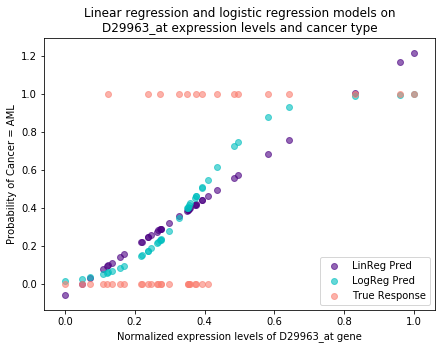

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))

colors = ['indigo','c', 'salmon']
label_text = ['LinReg Pred', 'LogReg Pred', 'True Response']
responses = [pred_quant_train, pred_prob_train, y_train]

# and we loop over the different groups
for i, cur_resp in enumerate(responses):
    ax.scatter(x_train_norm['D29963_at'].values, cur_resp, label = label_text[i], color = colors[i], alpha = 0.6)

ax.set_xlabel('Normalized expression levels of D29963_at gene')
ax.set_ylabel('Probability of Cancer = AML')
ax.set_title('Linear regression and logistic regression models on\nD29963_at expression levels and cancer type')
ax.legend(loc = 'lower right')

plt.show()

The logistic regression model appears to be better suited for binary classification than the linear model. This model captures the binary nature of the class types, and its predictions are in accordance with the natural measure of y. 

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [29]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [30]:
mult_gene_logreg = LogisticRegression(C = 10000000, solver = 'newton-cg', max_iter = 250).fit(x_train_norm, y_train)

In [31]:
def cancer_class_acc_multlog(x_train, y_train) -> float:
    '''Takes feature dataset and response column and returns accuracy score for logistic regression model
    Args:
        x_train: feature dataset
        y_train: response column
    Returns:
        accuracy of classification
    '''
    pred_response = mult_gene_logreg.predict(x_train)
    pred_prob = mult_gene_logreg.predict_proba(x_train)
    result = accuracy_score(y_train, pred_response)
    return (result, pred_prob)

In [32]:
acc_train_multlog, pred_prob_train_mult = cancer_class_acc_multlog(x_train_norm, y_train)
acc_test_multlog, pred_prob_test_mult = cancer_class_acc_multlog(x_test_norm, y_test)
print('Multiple logistic regression, Training Classification Accuracy: {}'.format(acc_train_multlog))
print('Multiple logistic regression, Test Classification Accuracy: {}'.format(acc_test_multlog))

Multiple logistic regression, Training Classification Accuracy: 1.0
Multiple logistic regression, Test Classification Accuracy: 1.0


This multiple logistic regression model has a classification accuracy of 1.0 on both the training and test sets. This coule be because we overfit the data with thousands more predictors than observations. The predicted probabilities of these sets might show a different story.

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

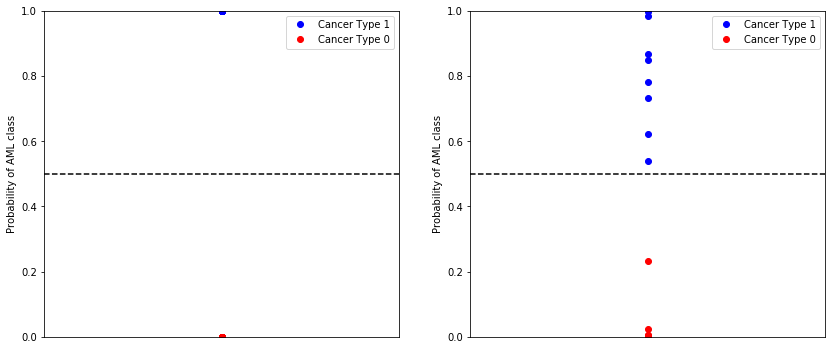

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6))

visualize_prob(mult_gene_logreg, x_train_norm, y_train, axs[0])
visualize_prob(mult_gene_logreg, x_test_norm, y_test, axs[1])

Yes, there is a difference in the training and test plots (left and right, respectively). Since there are thousands more predictors than observations, the model fits the training data perfectly; cancer type 0 and cancer type 1 are both predicted accurately on the training set. 

While the predictions in the test set lie on the appropriate side of the horizontal line for their classifications (ie the blue dots are all above 0.5, as they should be for AML, and the red are below 0.5 for ALL), the probabilities vary greatly. There appears to be one data point in the test set that is close to 0.5, with another close to 0.6. 

In [34]:
close_5 = []
for pred in pred_prob_test_mult[:,1]:
    if 0.35 <= pred <= 0.65:
        close_5.append(pred)
    else:
        pass
close_5

[0.6220903882076201, 0.5376467973523182]

There are two points that are close to 0.5: one with a probability of 53.8% of being AML and the other 62.2% chance. These points are very close to the boundary of 50% (particularly the 53.8% point) and could potentially fall into either class of cancer. There is a chance that, depending on the decided upon boundary, these points could be classified incorrectly, therefore predicting the wrong cancer type.

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [35]:
def make_bootstrap_sample(dataset_X, dataset_y, size = None) -> tuple:
    '''Take training dataset features and target, return bootstrapped datasets
    Args:
        dataset_X: training dataset features; dataset_y = training dataset target
    Returns:
        tuple of boostrapped training features as a pandas dataframe 
        and bootstrapped training target as a numpy array
    '''
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")

    sample_indices = np.random.choice(size, size=size, replace=True)
    bootstrap_dataset_X = dataset_X.iloc[sample_indices]
    bootstrap_dataset_y = dataset_y[sample_indices]
    
    return (bootstrap_dataset_X, bootstrap_dataset_y) 


def calculate_coefficients(dataset_X, dataset_y, model) -> list:
    '''Take bootstrapped training dataset features and target and return lin reg coefficients
    Args:
         dataset_X: pandas dataframe, dataset_y: numpy array, model to fit
    Return:
        dictionary containing bootstrap feature coefficients
    '''
    keys = tuple(dataset_X.columns.values)
    bootstrap_model = model.fit(dataset_X, dataset_y)
    coefficients_dictionary = dict(zip(keys, bootstrap_model.coef_[0]))
    return coefficients_dictionary

def get_significant_predictors(regression_coefficients, significance_level):
    '''Take list of regression coefficient dictionaries and return significant features
    Args:
        regression_coefficients: list of dictionaries
        significance_level: percent at which your testing for statistical significant (eg 5% input as 5)
    Returns:
        list of significant features
    '''
    keys = regression_coefficients[0].keys()
    significant_coefficients = []
    values_intervals = [] # return confidence intervals (as a check)
    for i, key in enumerate(keys):     
        values = [line[key] for line in regression_coefficients]
        # 5% significance level is equal to a lower limit percentile of 2.5% and an upper limit of 97.5%
        lower_limit, upper_limit = np.percentile(values, 
                                                 [significance_level/2, 100-significance_level/2])
        if not lower_limit <= 0 <= upper_limit:
            significant_coefficients.append(key)
            values_intervals.append([lower_limit, upper_limit])
        else:
            pass
    # return the significant coefficients as a list of strings
    return significant_coefficients, values_intervals

In [36]:
N = 1000
regression_coefficients = []
for i in range(N):
    bootstrap_dataset_X, bootstrap_dataset_y = make_bootstrap_sample(x_train_norm, y_train)
    coef_dict = calculate_coefficients(bootstrap_dataset_X, bootstrap_dataset_y, 
                                       LogisticRegression(C = 10000000, solver = 'newton-cg', max_iter = 250))
    regression_coefficients.append(coef_dict)

In [37]:
genes_significant_bootstrap, conf_intervals = get_significant_predictors(regression_coefficients, 5)
len(genes_significant_bootstrap)

1931

In [38]:
genes_significant_bootstrap

['AFFX-BioC-3_at',
 'AFFX-BioB-3_st',
 'hum_alu_at',
 'AFFX-DapX-5_at',
 'AFFX-LysX-3_at',
 'AFFX-PheX-5_at',
 'AFFX-HUMISGF3A/M97935_MA_at',
 'AFFX-HUMRGE/M10098_5_at',
 'AFFX-HUMRGE/M10098_M_at',
 'AFFX-HUMRGE/M10098_3_at',
 'AFFX-M27830_5_at',
 'AFFX-M27830_M_at',
 'AB000449_at',
 'AB000466_at',
 'AB000895_at',
 'AB001325_at',
 'AB002559_at',
 'AB003698_at',
 'AB004884_at',
 'AC000062_at',
 'AC000064_cds1_at',
 'AC002115_cds3_at',
 'AF001294_at',
 'AF002700_at',
 'AF005043_at',
 'AF006084_at',
 'AF009301_at',
 'AF009426_at',
 'AF010193_at',
 'AF014958_at',
 'AF015913_at',
 'AF015950_at',
 'AJ000480_at',
 'AJ001421_at',
 'D00017_at',
 'D00726_at',
 'D00760_at',
 'D10495_at',
 'D11086_at',
 'D12625_at',
 'D13118_at',
 'D13315_at',
 'D13628_at',
 'D13637_at',
 'D13639_at',
 'D13642_at',
 'D13748_at',
 'D13969_at',
 'D14533_at',
 'D14658_at',
 'D14659_at',
 'D14660_at',
 'D14661_at',
 'D14664_at',
 'D14811_at',
 'D14838_at',
 'D15050_at',
 'D16217_at',
 'D16227_at',
 'D16350_at',
 'D164

In [39]:
conf_intervals

[[-0.06240010585523801, -0.004357627384742481],
 [-0.04082423692767875, -0.005425862186179319],
 [0.012171862729471915, 0.09011004154370626],
 [-0.029373056544072452, -0.0005825256266119728],
 [0.0007664857280592404, 0.029157719051340777],
 [0.0005773756856250685, 0.06518255135096401],
 [0.0042403464024118745, 0.0349802904455949],
 [-0.07490041574486336, -0.0009803503473417643],
 [-0.06187885436344617, -0.0008699324197415198],
 [-0.08054256486197665, -0.00903407316655828],
 [-0.0717178272826941, -0.013751605576991194],
 [-0.06379900217034955, -0.015438163424810197],
 [-0.052581580488105115, -0.020840249472424518],
 [-0.06965176525623236, -0.017900195076217224],
 [-0.06055910065157921, -0.002017122324600016],
 [0.003889365207061718, 0.04782078945178521],
 [0.03961085458013389, 0.09993275016539217],
 [-0.03387216589336675, -0.002151685606990655],
 [-0.052052624902938716, -0.0042636245878329366],
 [-0.0760963640611493, -0.0009509195892989555],
 [0.01868952891855477, 0.06619221557276572],


In [40]:
print('{} coefficients are significantly different from zero at a 5% significance level.'.format(
    len(genes_significant_bootstrap)))

1931 coefficients are significantly different from zero at a 5% significance level.


## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [41]:
def V_c(d):
    """
    Calculate the volume of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

As a function of d, the proportion of the hypercube's volume that is contained within the hypersphere is: $\frac{V_s(d)}{V_c(d)}$ = $\frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)2^d}$

As $d$ gets very large, the proportion of the hypercube's volume that is contained within the sphere approaches zero. As $d$ increases, the volume of the hypercube grows by a power(s) of two, whereas the volume of the hypershere decreases and approaches zero. The denominator of the hypersphere volume grows much faster than the numerator (the denominator grows similarly to the factorial function, whereas the numerator only grows by a power(s) of pi), therefore the volume approaches zero.

This is confirmed with the below calculations.

In [42]:
def cube_in_sphere(d):
    '''
    Calculate how much of a hypercube is contained within a 
    hypersphere, which is inscribed inside of the hypercube
    '''
    return V_s(d)/V_c(d)

In [43]:
d_list = [2, 3, 5, 10, 20, 50, 100, 250, 500]
ratio_sphere_cube = np.zeros(len(d_list))
for i, cur_d in enumerate(d_list):
    ratio_sphere_cube[i] = cube_in_sphere(cur_d)
ratio_df = pd.DataFrame({r'dimension': d_list, 
                         'ratio_sphere_to_cube': ratio_sphere_cube})
ratio_df

,dimension,ratio_sphere_to_cube
0,2,7.853982e-01
1,3,5.235988e-01
2,5,1.644934e-01
3,10,2.490395e-03
4,20,2.461137e-08
5,50,1.536743e-28
6,100,1.868182e-70
7,250,4.087515e-223
8,500,0.000000e+00


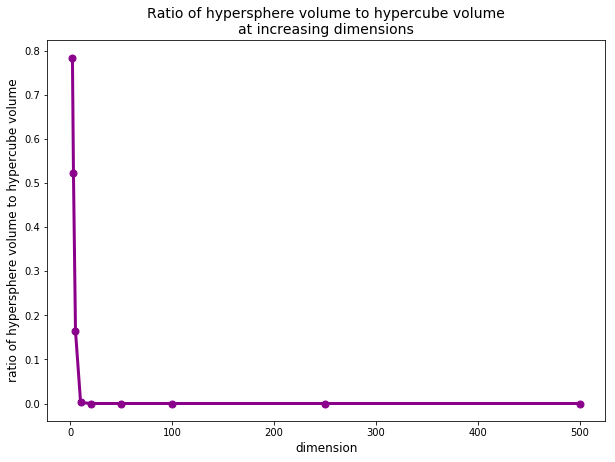

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

ax.plot(ratio_df['dimension'], ratio_df['ratio_sphere_to_cube'], 'o-', 
        markersize = 7, lw = 3, color = 'darkmagenta');
ax.set_xlabel('dimension', fontsize = 12)
ax.set_ylabel('ratio of hypersphere volume to hypercube volume', fontsize = 12)
ax.set_title('Ratio of hypersphere volume to hypercube volume\nat increasing dimensions', fontsize = 14)

plt.show()

At higher dimensions, the majority of the hypercube volume is outside of the hypersphere.

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [47]:
pca_30_transformer = PCA(30).fit(x_train_norm)
x_train_30d = pca_30_transformer.transform(x_train_norm)
x_test_30d =  pca_30_transformer.transform(x_test_norm)
np.cumsum(pca_30_transformer.explained_variance_ratio_)

array([0.15889035, 0.27317829, 0.33914119, 0.3870151 , 0.42957185,
       0.46789439, 0.50053032, 0.52950387, 0.55619709, 0.58074806,
       0.60440367, 0.62741071, 0.64863686, 0.66873622, 0.68841059,
       0.70768316, 0.72622259, 0.74356872, 0.76077827, 0.7773256 ,
       0.79281807, 0.80798491, 0.82297995, 0.83725127, 0.85111525,
       0.86445647, 0.87761542, 0.89045139, 0.90268704, 0.91447793])

29 principal components are needed to capture at least 90% of the variance. The first 29 principal components capture 90.3% of the variance.

In [48]:
pca_29_transformer = PCA(29).fit(x_train_norm)
x_train_29d = pca_29_transformer.transform(x_train_norm)
x_test_29d =  pca_29_transformer.transform(x_test_norm)
np.cumsum(pca_29_transformer.explained_variance_ratio_)

array([0.15889035, 0.27317829, 0.33914119, 0.3870151 , 0.42957185,
       0.46789439, 0.50053032, 0.52950387, 0.55619709, 0.58074806,
       0.60440367, 0.62741071, 0.64863686, 0.66873622, 0.68841059,
       0.70768316, 0.72622259, 0.74356872, 0.76077827, 0.7773256 ,
       0.79281807, 0.80798491, 0.82297995, 0.83725127, 0.85111525,
       0.86445647, 0.87761542, 0.89045139, 0.90268704])

In [49]:
mult_gene_logreg = LogisticRegression(C = 10000000, solver = 'newton-cg', max_iter = 250).fit(x_train_29d, y_train)

acc_train_multlog, pred_prob_train_mult = cancer_class_acc_multlog(x_train_29d, y_train)
acc_test_multlog, pred_prob_test_mult = cancer_class_acc_multlog(x_test_29d, y_test)
print('Mult. log. reg. on 29 principal components, Training Classification Accuracy: {}'.format(acc_train_multlog))
print('Mult. log. reg. on 29 principal components, Test Classification Accuracy: {}'.format(acc_test_multlog))

Mult. log. reg. on 29 principal components, Training Classification Accuracy: 1.0
Mult. log. reg. on 29 principal components, Test Classification Accuracy: 0.9696969696969697


Compared with 3.1, the classification accuracies of the training sets are identical. The classification accuracy of the test set on the model with 29 principal components is about 3.1% lower than the accuracy of the model built with all 7129 features. While the accuracy of the classification is lower with the lower dimensional model, the actual probabilities predicted by this model might be clustered together more on each side of the 0.5 boundary, providing confidence (not necessarily statistical) in the predictions and classifications.

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

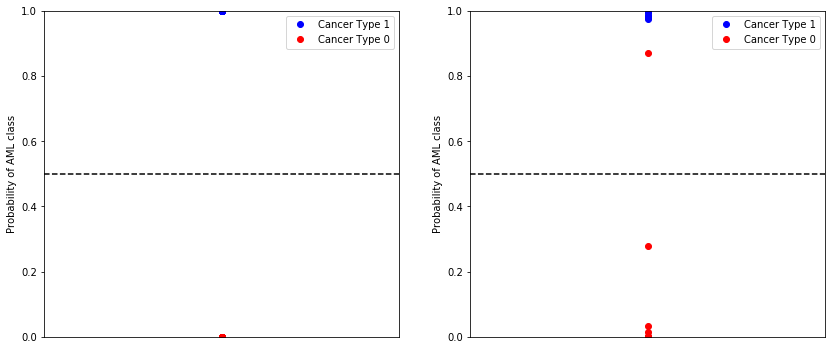

In [50]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6))

visualize_prob(mult_gene_logreg, x_train_29d, y_train, axs[0])
visualize_prob(mult_gene_logreg, x_test_29d, y_test, axs[1])

As suspected, the actual probabilities of the classes are less disperse in the test set of the lower dimensional model than the higher dimensional model. There are no longer any predictions that are close to the 0.5 boundary. However, there is one instance of one observation being assigned a probability that is contrary to its actual cancer classification (would appear to be AML when it's actually ALL - the red point above the dotted line).

The lower dimensional model yields comparable predictive power, but it results in probabilities that fall farther from the 0.5 boundary which might make the user of this model feel more confident in the classifications of this model. (Or if the boundary changes slightly, the predictions would still be the same.) Another advantage is the speed with which the model can be fit: the model with 29 dimensions is likely much faster than the model with 7129 dimensions. The model with the fewer dimensions also leads to a more useful model as the number of predictors is less than the number of observations in the training set, so the model is not overfitting to the training data.


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [51]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [52]:
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


In [53]:
data_train.dtypes

Biomarker 1    float64
Biomarker 2    float64
Diagnosis      float64
dtype: object

In [54]:
data_train.describe()

,Biomarker 1,Biomarker 2,Diagnosis
count,102.000000,102.000000,102.000000
mean,0.344213,0.136095,1.392157
std,0.830087,2.201512,0.677164
min,-2.302485,-11.512925,1.000000
25%,-0.105349,-1.076236,1.000000
50%,0.222351,0.641859,1.000000
75%,0.470010,1.273894,2.000000
max,4.032469,3.970292,3.000000


In [55]:
x_train = data_train.drop(['Diagnosis'], axis = 1)
x_test = data_test.drop(['Diagnosis'], axis = 1)
y_train = data_train['Diagnosis']
y_test = data_test['Diagnosis']

scaler = MinMaxScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

col_names = x_train.columns
x_train_norm = pd.DataFrame(x_train_norm, columns = col_names)
x_test_norm = pd.DataFrame(x_test_norm, columns = col_names)

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

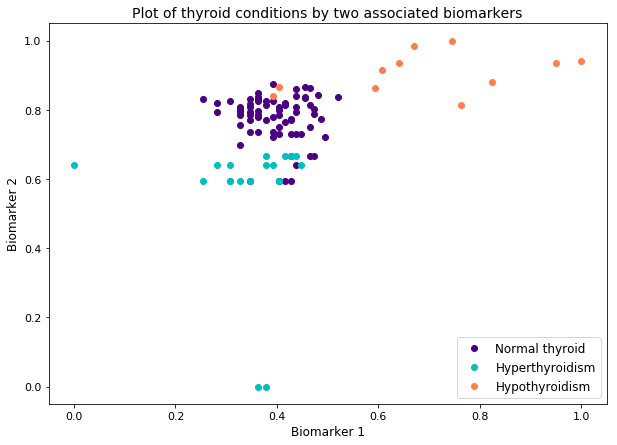

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

colors = ['indigo','c', 'coral']
thyroid_list = ["Normal thyroid", "Hyperthyroidism", "Hypothyroidism"]

for i, cur_thyroid in enumerate([1, 2, 3]):
    cur_df = x_train_norm.iloc[np.where(y_train == cur_thyroid)[0],:]
    ax.plot(cur_df.iloc[:,0], cur_df.iloc[:,1], 'o', color = colors[i], 
            label = thyroid_list[i], markersize = 6)
    
ax.set_xlabel('Biomarker 1', fontsize = 12)
ax.set_ylabel('Biomarker 2', fontsize = 12)
ax.set_title('Plot of thyroid conditions by two associated biomarkers', fontsize = 14)
ax.tick_params(labelsize = 11)
ax.legend(loc = 'lower right', fontsize = 12);

No, it does not appear that the data points can be separated well by a linear classifier. The boundaries between the classes appear to be non-linear and the spread of the three classes does not seem equal.

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


OvR logistic regression turns the multiple classes into a binary logistic regression, by defining the target class as '1' and all other classes as '0'. Then the model will predict the probability with which you'll hit the target class compared with all other classes. Multinomial logistic regression assumes there's a multinomial distribution, such the probability of the kth class depends on the probabilities of the previous k-1 classes, as the probabilities of all k classes must add up to 1. So, OvR gives you the probability of the target vs all others and multinomial regression gives the probability of each class.

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [60]:
c_list = [.00001, .001, .01, .1, 1, 10, 100, 1000, 10000]
ovr_thyroid = LogisticRegressionCV(Cs = c_list, penalty = 'l2', solver = 'newton-cg', max_iter=250, 
                                   multi_class = 'ovr', random_state = 42).fit(x_train_norm, y_train)
multi_thyroid = LogisticRegressionCV(Cs = c_list, penalty = 'l2', solver = 'newton-cg', max_iter=250, 
                                   multi_class = 'multinomial', random_state = 42).fit(x_train_norm, y_train)

In [61]:
ovr_thyroid_score_test = ovr_thyroid.score(x_test_norm, y_test)
multi_thyroid_test = multi_thyroid.score(x_test_norm, y_test)
print('OvR accuracy score on test set: {0:.5f}'.format(ovr_thyroid_score_test))
print('Multinomial accuracy score on test set: {0:.5f}'.format(multi_thyroid_test))

OvR accuracy score on test set: 0.86726
Multinomial accuracy score on test set: 0.88496


In [62]:
print('The multinomial model predicts {0:.2f}% better than the OvR model.'.format(
    (multi_thyroid_test - ovr_thyroid_score_test)*100))

The multinomial model predicts 1.77% better than the OvR model.


As can be seen above, the multinomial model predicts slightly better than the OvR model.

In [63]:
ovr_thyroid_score_train = ovr_thyroid.score(x_train_norm, y_train)
ovr_linear_scores = {'model': 'ovr_linear_logreg', 'training': ovr_thyroid_score_train, 'test': ovr_thyroid_score_test}
multi_thyroid_train = multi_thyroid.score(x_train_norm, y_train)
multi_linear_scores = {'model': 'multi_linear_logreg', 'training': multi_thyroid_train, 'test': multi_thyroid_test}

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [64]:
def gen_df_higher_orders(df, d):
    '''
    Generate higher order datasets with interaction terms
    '''
    poly_model = PolynomialFeatures(d, include_bias = False)
    
    higher_orders = poly_model.fit_transform(df)
    
    feature_names = ['Bio1', 'Bio2', 'Bio1^2', 'Bio1*Bio2', 'Bio2^2']

    return pd.DataFrame(higher_orders, columns = feature_names)

In [65]:
def get_poly_dataset(dataset_train, dataset_test, d):
    '''
    Generate higher order datasets with interaction terms
    '''
    poly_model = PolynomialFeatures(d, include_bias = False)
    
    higher_orders_train = gen_df_higher_orders(dataset_train, d)
    higher_orders_test = gen_df_higher_orders(dataset_test, d)


    # scale higher order polynomial features
    scaler = MinMaxScaler().fit(higher_orders_train)

    poly_train = scaler.transform(higher_orders_train)
    poly_test = scaler.transform(higher_orders_test)
    
    col_names = higher_orders_train.columns
    poly_train = pd.DataFrame(poly_train, columns = col_names)
    poly_test = pd.DataFrame(poly_test, columns = col_names)
    
    return (poly_train, poly_test)

In [66]:
x_poly_train, x_poly_test = get_poly_dataset(x_train_norm, x_test_norm, 2)

#### Multinomial logistic regression model with polynomial terms

In [67]:
c_list = [.00001, .001, .01, .1, 1, 10, 100, 1000, 10000]
multi_thyroid_quad = LogisticRegressionCV(Cs = c_list, penalty = 'l2', solver = 'newton-cg', max_iter=250, 
                                   multi_class = 'multinomial', random_state = 42).fit(x_poly_train, y_train)
multi_quad_score_train = multi_thyroid_quad.score(x_poly_train, y_train)
multi_quad_score_test = multi_thyroid_quad.score(x_poly_test, y_test)
multi_quad_scores = {'model': 'poly_logreg', 'training': multi_quad_score_train, 'test': multi_quad_score_test}
print('Quadratic terms, multinomial accuracy score on training set: {0:.5f}'.format(multi_quad_score_train))
print('Quadratic terms, multinomial accuracy score on test set: {0:.5f}'.format(multi_quad_score_test))

Quadratic terms, multinomial accuracy score on training set: 0.89216
Quadratic terms, multinomial accuracy score on test set: 0.88496


I was a little shocked that the accuracy scores for the model with quadratic terms (and an interaction term) had an identical accuracy score to the model with only linear terms. I thought I might be using the wrong scoring function (despite reading the documentation that showed multinomial scoring for accuracy_score was calculated the same as the .score for the multinomial LogisticRegression), so I did the below. I then realized that while the predictions of the classifications might be identical, the predictions of probabilities did differ between the two models.

In [68]:
multi_thyroid_quad.predict_proba(x_poly_train)

array([[9.65714781e-01, 1.09862507e-02, 2.32989679e-02],
       [9.55483400e-01, 6.29159466e-03, 3.82250053e-02],
       [4.93685075e-01, 5.06033870e-01, 2.81054818e-04],
       [9.64177943e-01, 2.82421313e-02, 7.57992592e-03],
       [8.88071557e-01, 1.91475681e-03, 1.10013686e-01],
       [9.08228170e-01, 2.27741645e-03, 8.94944134e-02],
       [2.67348391e-01, 7.32580567e-01, 7.10421766e-05],
       [1.28188253e-01, 8.71800422e-01, 1.13249515e-05],
       [6.24686723e-01, 3.74791470e-01, 5.21807090e-04],
       [9.57152455e-01, 3.68029418e-02, 6.04460326e-03],
       [9.70253065e-01, 1.93598606e-02, 1.03870745e-02],
       [2.67348391e-01, 7.32580567e-01, 7.10421766e-05],
       [9.51644278e-01, 4.40280275e-02, 4.32769472e-03],
       [9.60244485e-01, 3.17758502e-02, 7.97966457e-03],
       [7.06189278e-01, 2.92866522e-01, 9.44200009e-04],
       [9.48006874e-01, 4.66876096e-02, 5.30551674e-03],
       [9.66633066e-01, 1.70694161e-02, 1.62975177e-02],
       [9.50688229e-01, 6.15484

In [69]:
multi_thyroid.predict_proba(x_train_norm)

array([[9.75049759e-01, 9.60246314e-03, 1.53477774e-02],
       [9.64378997e-01, 5.55984079e-03, 3.00611622e-02],
       [4.93112218e-01, 5.06863653e-01, 2.41294739e-05],
       [9.69861444e-01, 2.63400241e-02, 3.79853216e-03],
       [8.83571198e-01, 1.70190494e-03, 1.14726897e-01],
       [9.05332265e-01, 2.05894686e-03, 9.26087879e-02],
       [2.41749188e-01, 7.58247769e-01, 3.04228585e-06],
       [9.65929318e-02, 9.03406804e-01, 2.64510995e-07],
       [6.35107643e-01, 3.64830047e-01, 6.23096151e-05],
       [9.63160055e-01, 3.41252065e-02, 2.71473866e-03],
       [9.75672328e-01, 1.82770724e-02, 6.05059975e-03],
       [2.41749188e-01, 7.58247769e-01, 3.04228585e-06],
       [9.55068459e-01, 4.30897983e-02, 1.84174281e-03],
       [9.68010954e-01, 2.83061258e-02, 3.68292011e-03],
       [7.27009628e-01, 2.72861170e-01, 1.29201402e-04],
       [9.55652555e-01, 4.22294039e-02, 2.11804107e-03],
       [9.76217104e-01, 1.46860861e-02, 9.09681032e-03],
       [9.61811569e-01, 5.30362

In [70]:
y_train

0      1.0
1      1.0
2      2.0
3      1.0
4      1.0
5      1.0
6      2.0
7      2.0
8      2.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     2.0
15     1.0
16     1.0
17     1.0
18     1.0
19     2.0
20     1.0
21     3.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     2.0
28     1.0
29     2.0
      ... 
72     2.0
73     1.0
74     3.0
75     1.0
76     2.0
77     1.0
78     1.0
79     1.0
80     1.0
81     1.0
82     1.0
83     1.0
84     1.0
85     1.0
86     3.0
87     2.0
88     2.0
89     3.0
90     1.0
91     1.0
92     1.0
93     1.0
94     1.0
95     2.0
96     1.0
97     1.0
98     2.0
99     1.0
100    1.0
101    1.0
Name: Diagnosis, Length: 102, dtype: float64

In [71]:
accuracy_score(y_test, multi_thyroid.predict(x_test_norm))

0.8849557522123894

In [72]:
accuracy_score(y_test, multi_thyroid_quad.predict(x_poly_test))

0.8849557522123894

#### Linear discriminant analysis

In [73]:
lda_thyroid = LinearDiscriminantAnalysis().fit(x_train_norm, y_train)

lda_thyroid_score_train = lda_thyroid.score(x_train_norm, y_train)
lda_thyroid_score_test = lda_thyroid.score(x_test_norm, y_test)
lda_scores = {'model': 'lda', 'training': lda_thyroid_score_train, 'test': lda_thyroid_score_test}
print('LDA accuracy score on training set: {0:.5f}'.format(lda_thyroid_score_train))
print('LDA accuracy score on test set: {0:.5f}'.format(lda_thyroid_score_test))

LDA accuracy score on training set: 0.87255
LDA accuracy score on test set: 0.83186


#### Quadratic discriminant analysis

In [74]:
qda_thyroid = QuadraticDiscriminantAnalysis().fit(x_train_norm, y_train)

qda_thyroid_score_train = qda_thyroid.score(x_train_norm, y_train)
qda_thyroid_score_test = qda_thyroid.score(x_test_norm, y_test)
qda_scores = {'model': 'qda', 'training': qda_thyroid_score_train, 'test': qda_thyroid_score_test}
print('QDA accuracy score on training set: {0:.5f}'.format(qda_thyroid_score_train))
print('QDA accuracy score on test set: {0:.5f}'.format(qda_thyroid_score_test))

QDA accuracy score on training set: 0.87255
QDA accuracy score on test set: 0.84956


#### k-Nearest Neighbors

In [75]:
knn_thyroid_cv = np.zeros((15,3))
k_values = list(range(1, 16))
for i, k in enumerate(k_values):
    fitted_neighbors = KNeighborsClassifier(n_neighbors = k)
    knn_thyroid_cv[i,:] = cross_val_score(fitted_neighbors, x_train_norm, y_train, cv = 3)

knn_thyroid_cv_df = pd.DataFrame(knn_thyroid_cv, index = list(range(1,16)), columns = ['CV1', 'CV2', 'CV3'])
knn_thyroid_cv_df['meanCV'] = np.mean(knn_thyroid_cv, axis=1)

knn_thyroid_cv_df

,CV1,CV2,CV3,meanCV
1,0.885714,0.823529,0.939394,0.882879
2,0.800000,0.852941,0.909091,0.854011
3,0.885714,0.823529,0.939394,0.882879
4,0.800000,0.852941,0.909091,0.854011
5,0.828571,0.882353,0.939394,0.883439
6,0.828571,0.882353,0.878788,0.863237
7,0.857143,0.882353,0.939394,0.892963
8,0.800000,0.823529,0.909091,0.844207
9,0.800000,0.882353,0.939394,0.873916
10,0.771429,0.735294,0.878788,0.795170


Scores seem to decline after 7 neighbors, so will choose that as the ideal number of neighbors.

In [76]:
knn_optimal_thyroid = KNeighborsClassifier(n_neighbors = 7).fit(x_train_norm, y_train)
knn_thyroid_score_train = knn_optimal_thyroid.score(x_train_norm, y_train)
knn_thyroid_score_test = knn_optimal_thyroid.score(x_test_norm, y_test)
knn_scores = {'model': 'knn', 'training': knn_thyroid_score_train, 'test': knn_thyroid_score_test}
print('KNN accuracy score on training set: {0:.5f}'.format(knn_thyroid_score_train))
print('KNN accuracy score on test set: {0:.5f}'.format(knn_thyroid_score_test))

KNN accuracy score on training set: 0.92157
KNN accuracy score on test set: 0.87611


#### Comparison of all models

In [77]:
all_scores = [ovr_linear_scores, multi_linear_scores, multi_quad_scores, lda_scores, qda_scores, knn_scores]
scores_df = pd.DataFrame.from_dict(all_scores)
scores_df = scores_df[['model', 'training', 'test']]
scores_df

,model,training,test
0,ovr_linear_logreg,0.872549,0.867257
1,multi_linear_logreg,0.892157,0.884956
2,poly_logreg,0.892157,0.884956
3,lda,0.872549,0.831858
4,qda,0.872549,0.849558
5,knn,0.921569,0.876106


It appears that the strongest models were the multinomial logistic regression models, as they had the highest test set accuracy score. 

**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

In terms of classification prediction, the polynomial logistic regression model yielded the exact same accuracy as the model with only linear terms. However, when examining the the probabilitistic predictions of the linear and polynomial models, it does appear (by visualizing looking at the results) that the polynomial model predicts probabilities that have a heavier weight on the actual classification than the linear model. (See above work/calculations to investigate that.)

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [78]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    x = x.values
    y = y.values
    
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title, legend
    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Biomarker 1', fontsize = 17)
    ax.set_ylabel('Biomarker 2', fontsize = 17)

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

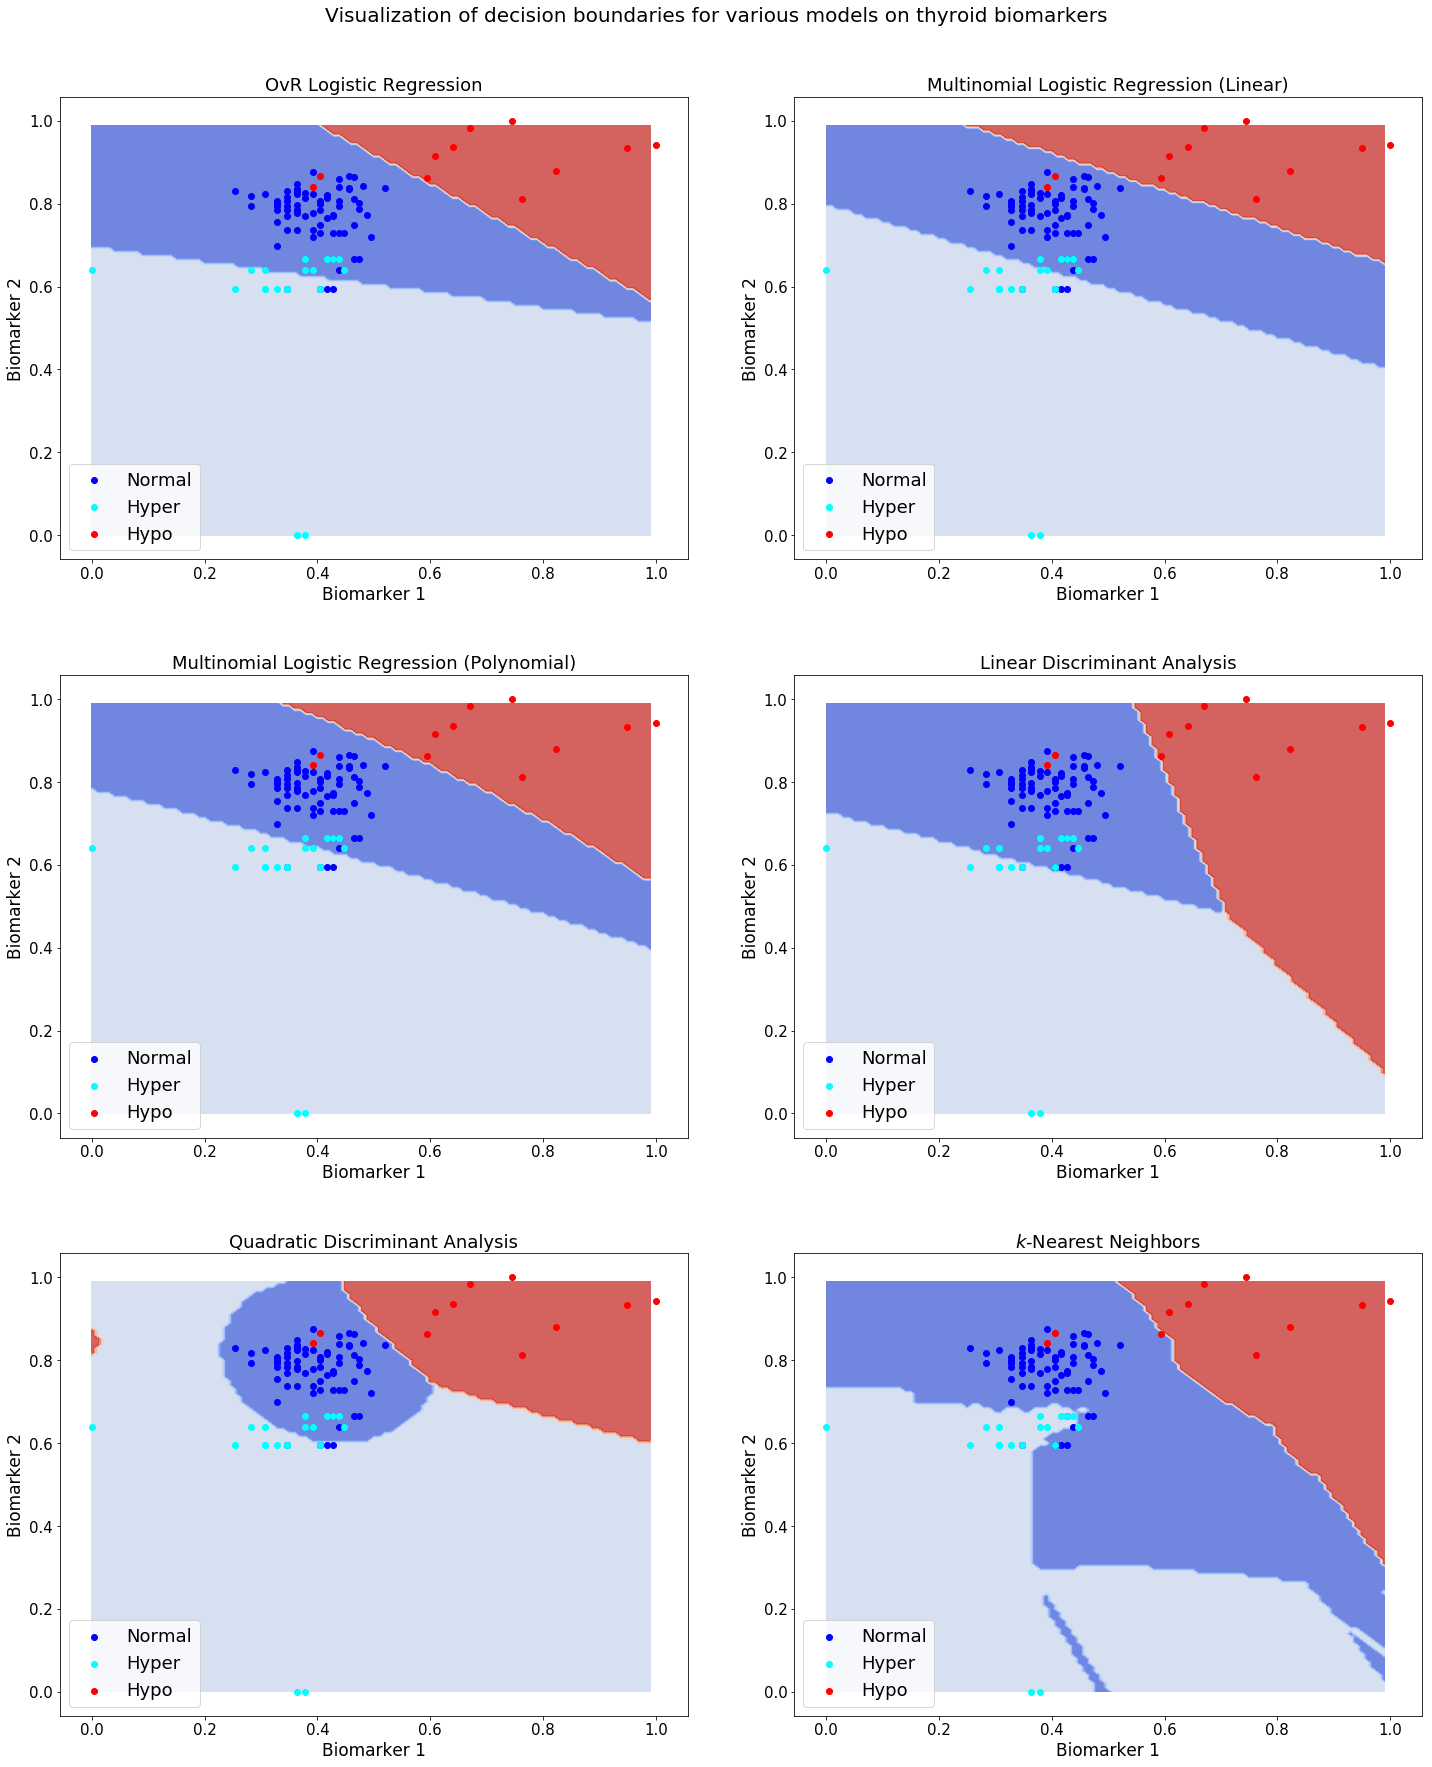

In [79]:
fig, axs = plt.subplots(3, 2, figsize = (20, 25))
axs = axs.ravel()

x_list = [x_train_norm, x_train_norm, x_poly_train, x_train_norm, x_train_norm, x_train_norm]
model_list = [ovr_thyroid, multi_thyroid, multi_thyroid_quad, lda_thyroid, qda_thyroid, knn_optimal_thyroid]
title_list = ['OvR Logistic Regression', 'Multinomial Logistic Regression (Linear)', 
              'Multinomial Logistic Regression (Polynomial)', 'Linear Discriminant Analysis',
             'Quadratic Discriminant Analysis', '$k$-Nearest Neighbors']
degree_list = [None, None, 2, None, None, None]

for i, cur_model in enumerate(model_list):
    plot_decision_boundary(x_list[i], y_train, cur_model, title_list[i], axs[i], degree_list[i])
    axs[i].tick_params(labelsize = 15)
    axs[i].legend(loc = 'lower left', fontsize = 18)

    
fig.suptitle('Visualization of decision boundaries for various models on thyroid biomarkers', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top = 0.93, hspace = .25, wspace = .17)

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

In the OvR model, the decision boundary between Hyper and Normal is more gradual than the same boundary seen in the multinomial logistic regression model of the linear terms. In OvR, the boundary between Hypo and Normal is much steeper than the same boundary in the multinomial logistic model of the linear terms; that boundary just about comes to a point with the boundary between Hyper and Normal. The boundaries in the multinomial logistic model of the polynomial seem to have steepness that is in between the steepness of the respective boundaries found in the OvR and linear term multinomial model. The boundaries in this polynomial term model also have some curve to them, which comes from the quadratic terms and/or the interaction term. The boundaries in the polynomial term model create similar 'shapes' to the linear term model (the boundary between Hypo and Normal doesn't come to a point, like it does in the OvR model). The main differences between OvR and the two multinomial models arise from the different methods the OvR vs multinomial models use. Since the OvR classifies by making the categories binary and comparing a target to all the others, the differences in decision boundaries make sense.

Yes, there is a difference between the LDA model and the linear logistic regression model. This is because LDA assumes multivariate normal distribution and equal covariance matrices (between the distributions of the biomarkers given the three classes of thyroid health), while logistic regression assumes neither of these. LDA seems to have looser boundaries for normal thyroid healthy, which could lead to misdiagnosis (or lack thereof) of thyroid conditions.

Yes, there is a difference between the QDA model and the quadratic logistic regression model. QDA assumes multivariate normality while the quadratic logistic regression does not. QDA has a much tighter boundary for normal thyroid health.

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

The primary difference that makes QDA more general is that it doesn't assume the covariance matrices of each class are equal. This manifests in the plots by the LDA model showing only linear boundaries, whereas the QDA model has a curved (almost circular) boundary around normal thyroid health. QDA can form non-linear boundaries between classes.